In [93]:
import anacal
import galsim
import numpy as np
import matplotlib.pyplot as plt
import batsim
import tqdm

from multiprocessing import Pool, cpu_count

## Example sent by Xiangchong

Effective measurement radius:  0.591272703375028


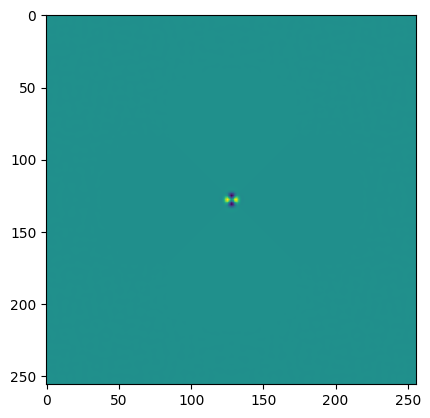

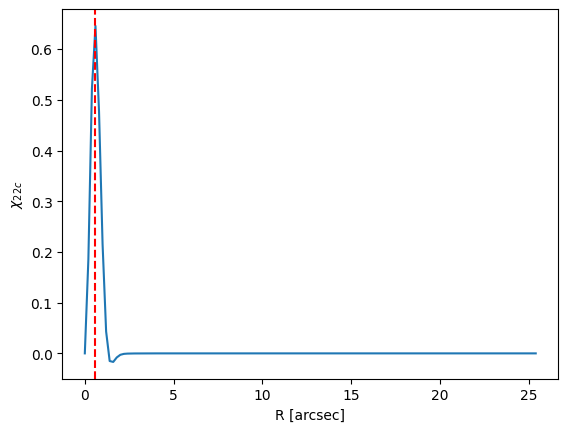

In [94]:
# We use a fine grids for the plot
pixel_scale = 0.2 # arcsec
fwhm = 0.8

# The expected LSST PSF
psf_obj = galsim.Moffat(fwhm=0.8, beta=2.5)
npix = 256
psf_data = psf_obj.shift(
    pixel_scale*0.5, pixel_scale*0.5,
).drawImage(nx=npix, ny=npix, scale=pixel_scale).array
psf_fourier = np.fft.rfft2(np.fft.fftshift(psf_data))
nord=6
det_nrot = 4
sigma_as = 0.52
mtask = anacal.fpfs.FpfsMeasure(
    mag_zero=25.3,
    psf_array=psf_data,
    pixel_scale=pixel_scale,
    sigma_arcsec=sigma_as,
    nord=nord,
    det_nrot=det_nrot,
)

# Shape kernel in Fourier space
chi22c_fourier = mtask.bfunc[mtask.di["m22c"]]
# The effecitve kernel in Configuration space
chi22c = np.fft.fftshift(np.fft.irfft2(chi22c_fourier / psf_fourier))
plt.figure()
plt.imshow(chi22c)


x = (np.arange(npix)[npix//2:] - npix//2) * pixel_scale
y = chi22c[npix//2, npix//2:]
y_norm = np.sqrt(np.sum(y ** 2.0))
y = y / y_norm
plt.figure()
plt.plot(x, y)
plt.xlabel("R [arcsec]")
plt.ylabel(r"$\chi_{22c}$")

# take moments as weights to find effective measurement radius
r_eff = np.average(x, weights=y)
print("Effective measurement radius: ", r_eff)
plt.axvline(r_eff, color="red", linestyle="--")

## Checking truncation works as intended

In [95]:
def test_truncation(hlr, npix, pixel_scale, clip_radius):

    indx = np.arange(-int(npix / 2), int((npix + 1) / 2), 1) * pixel_scale
    indy = np.arange(-int(npix / 2), int((npix + 1) / 2), 1) * pixel_scale
    inds = np.meshgrid(indy, indx, indexing="ij")
    
    # coords in shape of (2, npoints), in order of [x, y]
    coords = np.vstack([np.ravel(_) for _ in inds[::-1]])
    x, y = coords

    radial_dist = np.sqrt(abs(x) ** 2 + abs(y) ** 2)
    rwf = (radial_dist) / hlr

    # fix shear beyond rfw >= clip_radius
    rwf = np.clip(rwf, 0, clip_radius)

    shear = 0.01*rwf**0.8

    return radial_dist, shear, rwf

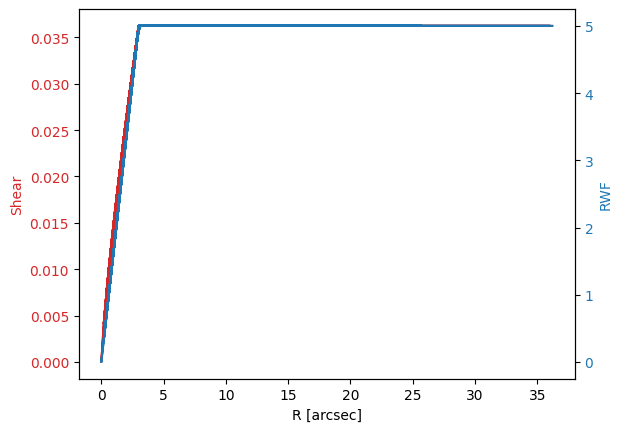

In [96]:
hlr = 0.6 # arcsec 
clip_radius = 5

radial_dist, shear, rwf = test_truncation(hlr, npix, pixel_scale, clip_radius)

# twin axes plot of shear and rwf
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('R [arcsec]')
ax1.set_ylabel('Shear', color=color)
ax1.plot(radial_dist, shear, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('RWF', color=color)
ax2.plot(radial_dist, rwf, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

## Attempt to recreate for a single galaxy

 half light radius: [[0.12742528 0.0313103  0.14777184]]
0.14777184182187433


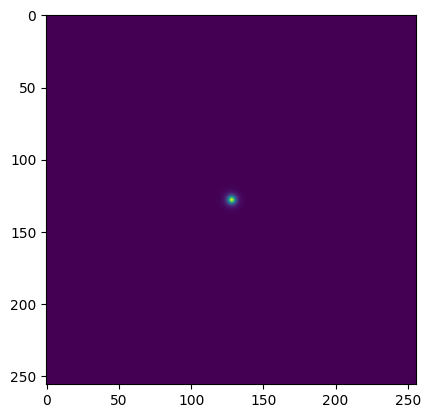

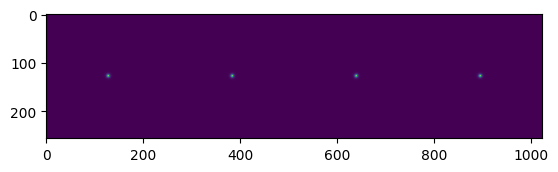

In [97]:
# Load in the cosmos catalog
cosmos_cat = galsim.COSMOSCatalog()
n_gal = 1

inds = np.random.choice(len(cosmos_cat), n_gal, replace=False)
gal_obj = cosmos_cat.makeGalaxy(n_random=n_gal, gal_type='parametric')
record = cosmos_cat.getParametricRecord(inds)

# Print details of the galaxy
print(' half light radius:', record['hlr'])

if record['use_bulgefit']:
    hlr = record['hlr'][0][2]
else:
    hlr = record['hlr'][0][0]

print(hlr)

# rotate to cancel shape noise
nrot = 4
rotated_gals = []
for i in range(nrot):
    rot_ang = np.pi / nrot * i
    ang = rot_ang * galsim.radians
    rotated_gals.append(gal_obj.rotate(ang))

lens_transform = batsim.LensTransform(
    gamma1=0.02,
    gamma2=0.00,
    kappa=0
)

# Create IA transform
a_ia = 0.001
b_ia = 0.8
clip_radius = 5 # units of HLR

ia_transform = batsim.IaTransform(
    scale=pixel_scale,
    hlr=hlr,
    A=a_ia,
    beta=b_ia, # best first Georgiou19+
    phi = np.radians(0),
    clip_radius=clip_radius # clip the transform at 5*hlr to prevent edge effects
)

gal_img_list = batsim.simulate_galaxy_batch(
        ngrid=npix,
        pix_scale=pixel_scale,
        gal_obj_list=rotated_gals,
        transform_obj=ia_transform,
        psf_obj=psf_obj,
        draw_method='auto',
        nproc=nrot,
        truncate_ratio=1
    )

plt.figure()
plt.imshow(gal_img_list[0])

# concatenate the images
for i in range(nrot):
    if i == 0:
        gal_img = gal_img_list[i]
    else:
        gal_img = np.concatenate((gal_img, gal_img_list[i]), axis=1)

# Plot the galaxy
plt.figure()
plt.imshow(gal_img)

In [98]:
# Spin-2 Shape kernel in Fourier space
chi22c_fourier = mtask.bfunc[mtask.di["m22c"]]
# The effecitve kernel in Configuration space
chi22c = np.fft.fftshift(np.fft.irfft2(chi22c_fourier / psf_fourier))
# Shear response Shape kernel in Fourier space
responfun_fourier = (mtask.bfunc[mtask.di["m00"]] - mtask.bfunc[mtask.di["m40"]]) / np.sqrt(2.0)
# The effecitve kernel in Configuration space
responfun = np.fft.fftshift(np.fft.irfft2(responfun_fourier / psf_fourier))

e_sum = 0.0
res_sum = 0.0
for i in range(nrot
               ):
    gal_data = gal_img[:, i*npix:(i+1)*npix]
    e_sum += np.sum(chi22c*gal_data) 
    res_sum += np.sum(responfun*gal_data)

measured_shear = e_sum / res_sum
print("Measured shear: ", measured_shear)

Measured shear:  0.0010774840730840315


Measurement radius from shear (HLR):  2.6109613226984556
Measurement radius from moments (HLR):  4.001254204354806


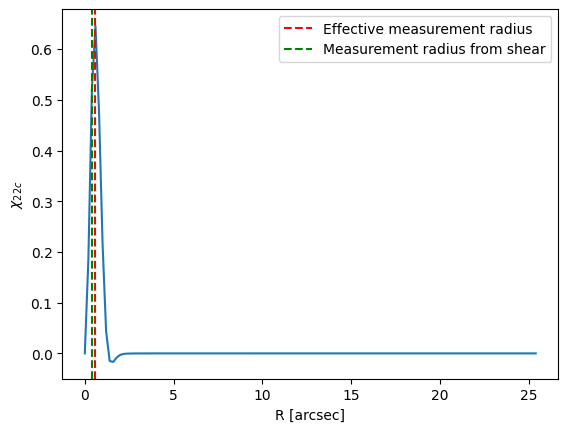

In [99]:
# Determime expected shear
a_rwf = galsim.Shear(g1=measured_shear).e1
rwf = (a_rwf / a_ia) ** (1/b_ia)
print("Measurement radius from shear (HLR): ", rwf)
print("Measurement radius from moments (HLR): ", r_eff/hlr)

plt.figure()
plt.plot(x, y)
plt.xlabel("R [arcsec]")
plt.ylabel(r"$\chi_{22c}$")

# take moments as weights to find effective measurement radius
r_eff = np.average(x, weights=y)
plt.axvline(r_eff, color="red", linestyle="--", label="Effective measurement radius")
plt.axvline(rwf*hlr, color="green", linestyle="--", label="Measurement radius from shear")
plt.legend()